In [23]:
import json
import re
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 12})
plt.rcParams['text.latex.preamble'] = ''
plt.rcParams.update({
    "text.usetex": True,
    "font.family": ['Aptos', 'Arial']
})

!mkdir -p insights

In [13]:
cleaned_path = 'outputs/cleaned.jsonl'
omit_path = 'outputs/omit_data.jsonl'
original_path = 'mainpipe_data_v1.jsonl'

In [14]:
def read_jsonl(path):
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            yield json.loads(line)

In [15]:
omit_records = list(read_jsonl(omit_path))

In [16]:
omit_reasons = Counter()

for omit_record in omit_records:
    reason = omit_record['reason']
    omit_reasons[reason] += 1

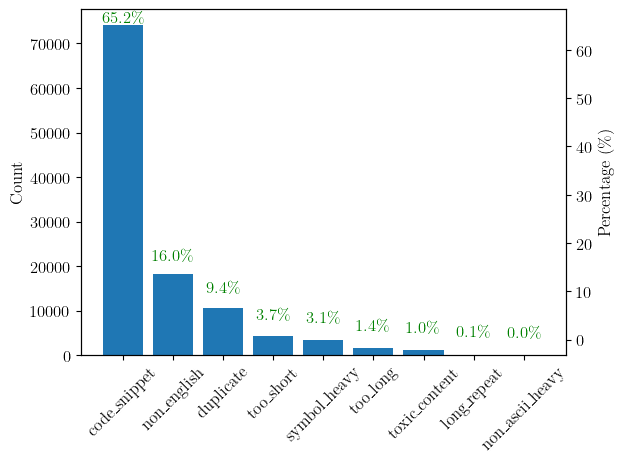

In [43]:
fig, ax = plt.subplots()
sorted_reasons = dict(sorted(omit_reasons.items(), key=lambda item: item[1], reverse=True))
ax.bar(sorted_reasons.keys(), sorted_reasons.values())
ax.tick_params(axis='x', labelrotation=45)
ax.set_ylabel('Count')
ax2 = ax.twinx()

total_omits = sum(sorted_reasons.values())
percentages = [count / total_omits * 100 for count in sorted_reasons.values()]
ax2.plot(sorted_reasons.keys(), percentages, color='orange', marker='o', linestyle='--', label='Percentage')
ax2.lines[0].set_visible(False)
# show percentage values on top of the points
for i, percentage in enumerate(percentages):
    ax2.text(i, percentage + 0.5, f'{percentage:.1f}\\%', color='green', ha='center')
ax2.set_ylabel('Percentage (\\%)')

fig.tight_layout()
plt.savefig('insights/omit-reasons.pdf', bbox_inches='tight')
plt.show()

In [18]:
cleaned_records = list(read_jsonl(cleaned_path))

In [19]:
cleaned_lengths = np.array([len(record['cleaned']) for record in cleaned_records])
omit_lengths = np.array([len(record['original']) for record in omit_records])

In [20]:
original_records = list(read_jsonl(original_path))
original_lengths = np.array([len(record['text']) for record in original_records])
del original_records

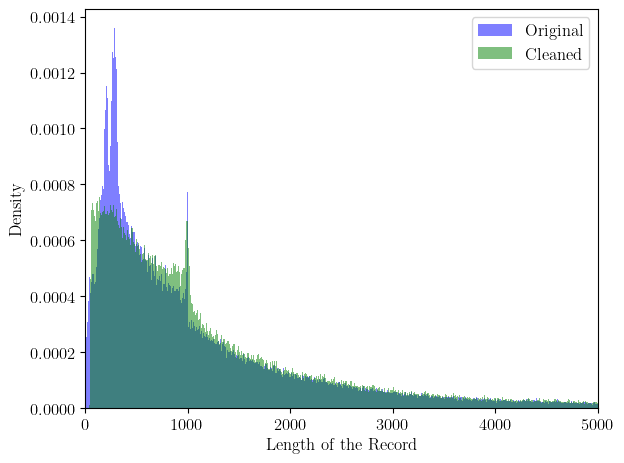

In [21]:
# Plot histogram of cleaned lengths and omit lengths side by side
fig, ax = plt.subplots()
# Define desired bin width
bin_width = 10
min_data = np.min(original_lengths)
max_data = np.max(original_lengths)
bins = np.arange(min_data, max_data + bin_width, bin_width)
ax.hist(original_lengths, bins=bins, alpha=0.5, label='Original', color='blue', density=True)
bin_width = 10
min_data = np.min(cleaned_lengths)
max_data = np.max(cleaned_lengths)
bins = np.arange(min_data, max_data + bin_width, bin_width)
ax.hist(cleaned_lengths, bins=bins, alpha=0.5, label='Cleaned', color='green', density=True)
ax.set_xlabel('Length of the Record')
ax.set_ylabel('Density')
ax.legend()
ax.set_xlim(0, 5000)
fig.tight_layout()
plt.savefig('insights/cleaned-vs-omit-lengths.pdf', bbox_inches='tight')
plt.show()

In [22]:
total_cleaned = 0
total_html_extracted = 0
total_anonymized = 0
for cleaned_record in cleaned_records:
    total_cleaned += 1
    if cleaned_record['html_extracted']:
        total_html_extracted += 1
    if cleaned_record['anonymized']:
        total_anonymized += 1
print(f'{total_cleaned=} {total_html_extracted=} {total_anonymized=}')
print('Out of the cleaned recoreds,')
print(f'HTML Extracted: {100*total_html_extracted/total_cleaned:.2f}%')
print(f'Anonymized: {100*total_anonymized/total_cleaned:.2f}%')

total_cleaned=155858 total_html_extracted=16445 total_anonymized=99281
Out of the cleaned recoreds,
HTML Extracted: 10.55%
Anonymized: 63.70%


In [28]:
total_person_redactions = 0
total_location_redactions = 0
total_ip_adress_redactions = 0
total_email_address_redactions = 0
total_phone_number_redactions = 0
total_pronouns_redactions = 0

from pipelib.components.modifiers.pii import PIIModifier

pronoun_pattern = '|'.join([re.escape(val) for val in PIIModifier.PRONOUN_MAP.values()])

for cleaned_record in cleaned_records:
    if cleaned_record['anonymized']:
        text = cleaned_record['cleaned']
        total_person_redactions += len(re.findall(f'(?=<PERSON>)', text))
        total_location_redactions += len(re.findall(f'(?=<LOCATION>)', text))
        total_ip_adress_redactions += len(re.findall(f'(?=<IP_ADDRESS>)', text))
        total_email_address_redactions += len(re.findall(f'(?=<EMAIL_ADDRESS>)', text))
        total_phone_number_redactions += len(re.findall(f'(?=<PHONE_NUMBER>)', text))

        total_pronouns_redactions += len(re.findall(pronoun_pattern, text))


print(f'{total_person_redactions=} {total_phone_number_redactions=}')
print(f'{total_location_redactions=} {total_ip_adress_redactions=}')
print(f'{total_email_address_redactions=} {total_phone_number_redactions=}')
print(f'{total_pronouns_redactions=}')

total_person_redactions=514279 total_phone_number_redactions=7260
total_location_redactions=416801 total_ip_adress_redactions=4890
total_email_address_redactions=2607 total_phone_number_redactions=7260
total_pronouns_redactions=262674


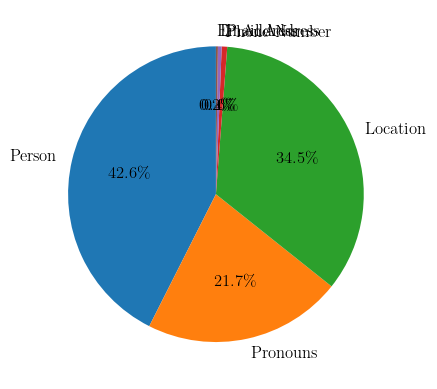

In [36]:
# draw a pie chart for the counts of redactions
fig, ax = plt.subplots()
sizes = [total_person_redactions, total_pronouns_redactions, total_location_redactions, total_phone_number_redactions, total_ip_adress_redactions, total_email_address_redactions]
labels = ['Person', 'Pronouns', 'Location', 'Phone Number', 'IP Address', 'Email Address']
# explode = [0, 0, 0, 0.5, 0.1, 0.1]
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90,  labeldistance=1.1)
plt.show()

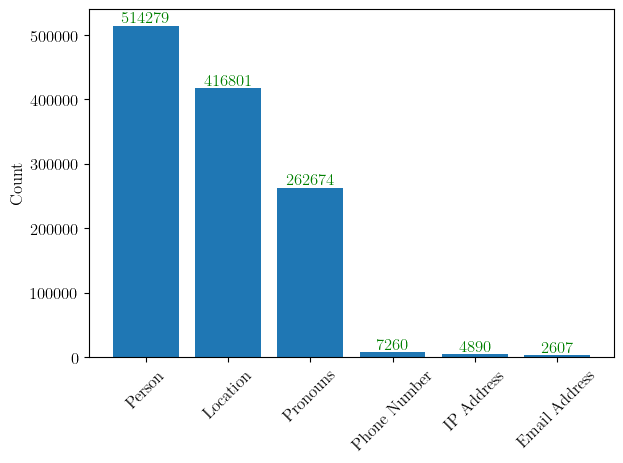

In [48]:
fig, ax = plt.subplots()
sizes = [total_person_redactions, total_location_redactions, total_pronouns_redactions, total_phone_number_redactions, total_ip_adress_redactions, total_email_address_redactions]
labels = ['Person','Location', 'Pronouns',  'Phone Number', 'IP Address', 'Email Address']
ax.bar(labels, sizes)

for i, size in enumerate(sizes):
    ax.text(i, size + 5000, f'{size}', color='green', ha='center')
ax.tick_params(axis='x', labelrotation=45)
ax.set_ylabel('Count')
fig.tight_layout()
plt.savefig('insights/redactions.pdf', bbox_inches='tight')
plt.show()